In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Lets begin with a review of derivatives.

In [4]:
def fx(x):
    return 3*x**2 -4*x+ 7

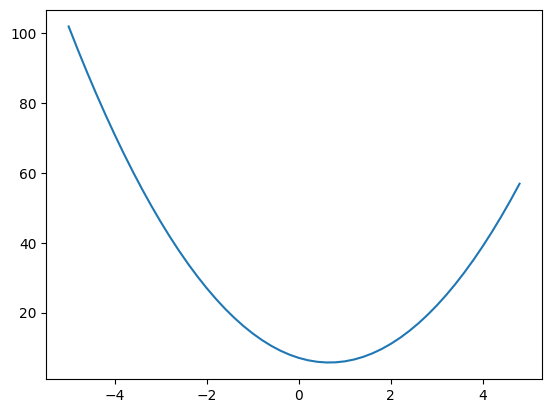

In [5]:
xs = np.arange(-5,5,0.2)
ys = fx(xs)
plt.plot(xs,ys)
plt.show()

In [6]:
h = 0.00001
x = 3
derivative = (fx(x+h)-fx(x))/h
print(derivative)

14.00003000000538


In [7]:
# point at which derivative to be calculated
a = 2.0
b = -3.0
c = 10.0

# function definition
g1 = a*b +c 

h = 0.00001
a+=h

g2 = a*b +c 

slope =  (g2-g1)/h
print('slope wrt a = ', slope) 

# its like extending the x+h definition to multiple dimensions
# slope = b, since partial derivative wrt 'a'


slope wrt a =  -3.000000000064062


## Dunder functions

Function definition of the type def `__add__`(): as compared to def add ():

This is a special method (dunder method) used to define the behavior of the + operator for instances of the class.
When you use a + b where a and b are objects of the class, Python internally calls a.`__add__`(b).
It makes operator overloading possible. 

__versus__

add is just a normal method without any special meaning in Python.
You have to explicitly call it like a.add(b).
It does not enable operator overloading.
i.e. you cannot call a+b where a and b are objects of the same class and expect natural addition. 


In [8]:
# example: 

class MyNumber:
    def __init__(self, value):
        self.value = value

    def __add__(self, other):
        return MyNumber(self.value + other.value)

a = MyNumber(5)
b = MyNumber(10)
c = a + b  # Internally calls a.__add__(b)
print(c.value)  # Output: 15

15


but if only add is defined:

In [9]:
class MyNumber:
    def __init__(self, value):
        self.value = value

    def add(self, other):
        return MyNumber(self.value + other.value)

a = MyNumber(5)
b = MyNumber(10)
c = a+b
# c = a.add(b)  # Explicit method call must be done
print(c.value)  # Output: 15

TypeError: unsupported operand type(s) for +: 'MyNumber' and 'MyNumber'

overloading `+` operator yields error!

# Visualising backprop

### Step-1: define basic ops

Now to visualize the nodes and children and backprop etc in action using grpahs, we define our custom class. It will include special data structures to store value, children and operation performed. 

In [25]:
class Value:

    def __init__(self, data, _children = () , _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        #__repr__ should return a printable representation of the object, most likely one of the ways possible to create this object. See official documentation here
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        sum = Value(self.data + other.data, (self, other), '+')
        return sum
    
    def __mul__(self, other):
        prod = Value(self.data * other.data, (self, other), '*')
        return prod


note that `__add__`, `__mul__` names are fixed, cannot use sum or product or any arbitrary names!

`__truediv__` for division and `__floordiv__` for mod operation etc are other functions.

In [26]:
a = Value(9.0, label='a')
b = Value(4.0, label = 'b')
c = Value(10.0, label = 'c')

p = a +c +b
p.label = 'p'

In [27]:
print(p._prev, "; operation = ",p._op)

{Value(data=4.0), Value(data=19.0)} ; operation =  +


In [32]:
e = a*b; e.label = 'e' # for better tracing in the graph
d = e + c
d.label = 'd'

print('children = ', d._prev,)
print('operator = ', d._op)
print('label = ', d.label)

children =  {Value(data=36.0), Value(data=10.0)}
operator =  +
label =  d


## Visualization of nodes and operators

using graphviz library and some custom code 

In [29]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Note: Graphviz is an opens source visualizing tool. And we have used its api. Graphviz can be installed from the internet and set it up using the exe file to your system.

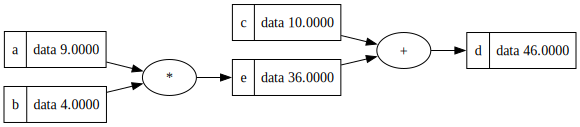

In [33]:
draw_dot(d)

In [ ]:
# Whole chain of variables:

a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b; e.label = 'e' # for better tracing in the graph
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')

L = d * f
L

Value(data=-8.0)

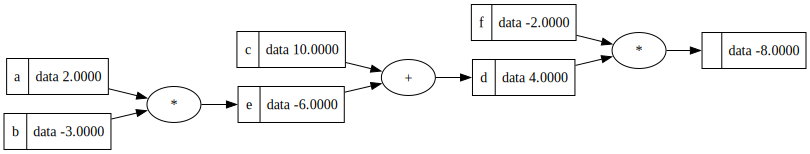

In [36]:
draw_dot(L)

__Recap__:
We have been able to build mathematical expressions and visualize them using + and * only so far. This constitutes the forward pass (Loss calculation for each data point). 

#### Now we will reverse and calculate the gradient along all the intermediate values. (backpass)

i.e. dL wrt a,b,c,d,e,f which will eventually come to reflect the weights of the neural networks. 